In [1]:
from IPython.display import display, Math, HTML, Image
import orbits

display(HTML("<h1>NGC 6397</h1>"))
# display(Image(url='https://upload.wikimedia.org/wikipedia/commons/9/99/P0321a.jpg', width=1024))

display(Math('\\text{{RA}} = {}^{{\\circ}}'.format(orbits.RA)))
display(Math('\\text{{DEC}} = {}^{{\\circ}}'.format(orbits.DEC)))
display(Math('\\mu_\\alpha \\cos\\delta = {} \\pm {}^{{\\circ}}'.format(*orbits.PMRA)))
display(Math('\\delta = {} \\pm {}^{{\\circ}}'.format(*orbits.PMDEC)))
display(Math('R_\\odot = {}\\text{{ kpc}}'.format(orbits.RSUN)))
display(Math('\\sigma = {}\\text{{ mas/yr}}'.format(orbits.SIGMA)))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [2]:
import gaia
import numpy as np

display(Math('N_\\text{{initial}} = {}'.format(len(gaia.data))))

<IPython.core.display.Math object>

In [3]:

# Clean out bad data
cut = gaia.data['bp_rp'] != 0

display(HTML('Cleaning for zero BP-RP'))
display(Math('N_\\text{{clean}} = {}'.format(np.sum(cut))))

<IPython.core.display.Math object>

In [4]:

# Perform a proper motion cut
cut &= np.abs(gaia.data['pmra'] - orbits.PMRA[0]) < (2 * gaia.data['pmra_error'])
cut &= np.abs(gaia.data['pmdec'] - orbits.PMDEC[0]) < (2 * gaia.data['pmdec_error'])


display(HTML('Proper motion cut'))
display(Math('\\mu_\\alpha \\cos\\delta_i - \\mu_\\alpha \\cos\\delta < 2 \\epsilon_{{\\mu_\\alpha \\cos\\delta_i}}'))
display(Math('\\mu_{\\delta_i }- \\mu_{\\delta} < 2 \\epsilon_{{\\mu_{\\delta_i}}}'))
display(Math('N_\\text{{pm}} = {}'.format(np.sum(cut))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [5]:

# Perform a statistical selection
chi2 = 5
cut &= (gaia.data['pmra'] - orbits.PMRA[0])**2 / (orbits.SIGMA**2 + gaia.data['pmra_error']**2) + \
       (gaia.data['pmdec'] - orbits.PMDEC[0])**2 / (orbits.SIGMA**2 + gaia.data['pmdec_error']**2) <= chi2


display(HTML('Statistical criterion cut'))
display(Math('''\\chi^2 = \\frac{(\\mu_\\alpha \\cos\\delta_i - \\mu_\\alpha \\cos\\delta)^2}{(\\sigma^2 + \\epsilon_{{\\mu_\\alpha \\cos\\delta_i}})^2} + \\
                \\frac{(\\mu_{\\delta_i} - \\mu_{\\delta_i})^2}{(\\sigma^2 + \\epsilon_{{\\mu_{\\delta_i}}})^2} \\le 5''')) 
display(Math('N_{{\\chi^2}} = {}'.format(np.sum(cut))))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [6]:

# Perform a colour-magnitude cut
from scipy import stats
from geom import angular_dist, deg2rad

# Seperate the cluster into inside 0.5 degree radius and outside.
distances = angular_dist(gaia.data['ra'], gaia.data['dec'], orbits.RA, orbits.DEC)
inside = distances < deg2rad(0.5)

# Find all of the faint stars (mag > 20.1) 
faint = gaia.data['phot_g_mean_mag'] > 20.1
bright = gaia.data['phot_g_mean_mag'] < 19

# Of the stars outside the 0.5 deg radius, determine if
# the angular separation is of the same distribution.
g1 = cut & ~inside & faint
g2 = cut & ~inside & ~faint
result = stats.kstest(distances[g1], distances[g2])

# If reasonably certain the two groups are different,
# throw away the faint ones.
if result.pvalue < 0.05:
    cut &= ~g1


display(HTML('Final selection'))
display(Math('N_\\text{{final}} = {}'.format(np.sum(cut))))

<IPython.core.display.Math object>

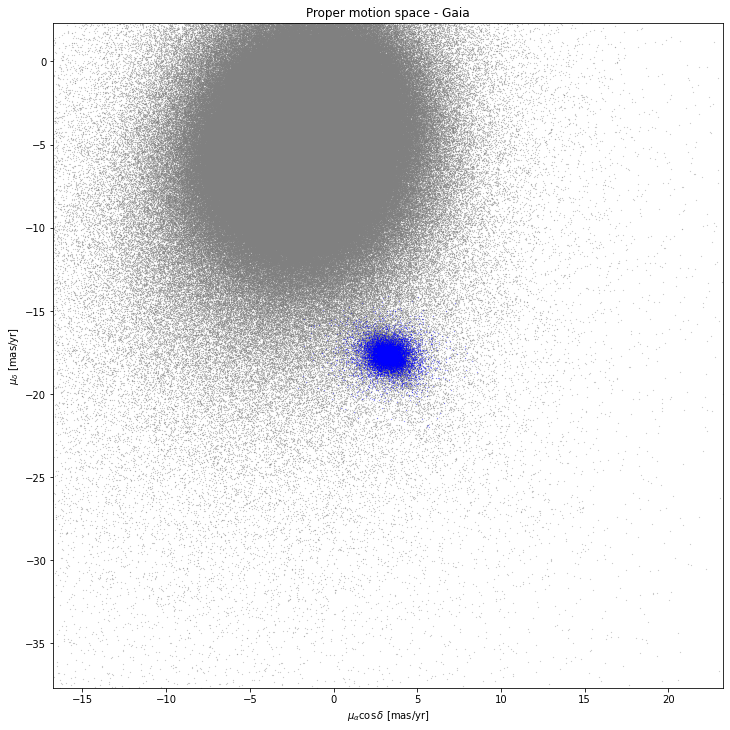

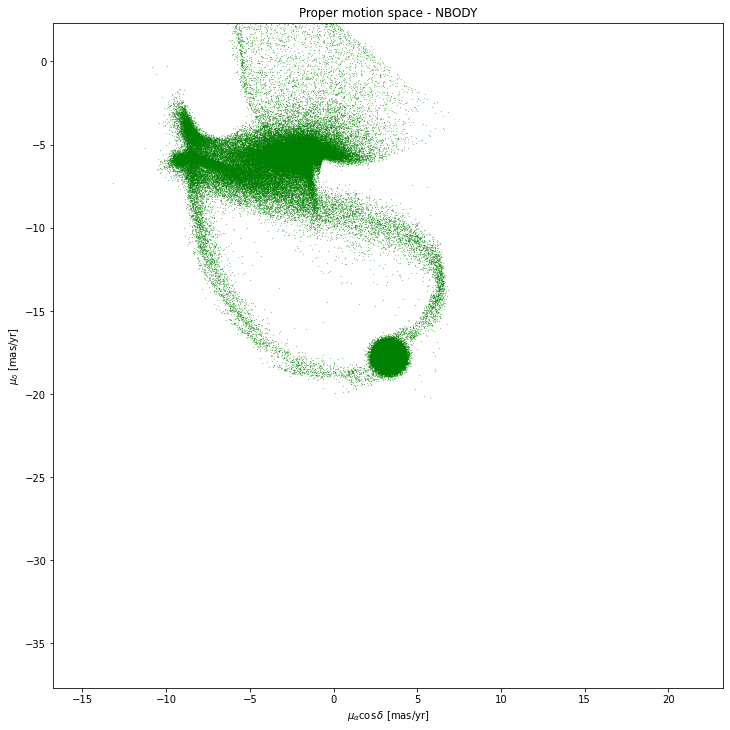

In [7]:
from astropy.visualization import quantity_support
quantity_support()  
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [12, 12]
mpl.rcParams['figure.dpi'] = 72

# Draw a proper motion diagram.
fig, ax = plt.subplots(ncols=1)

ax.set(
    title=r'Proper motion space - Gaia',
    xlim=[orbits.PMRA[0]-20, orbits.PMRA[0]+20],
    ylim=[orbits.PMDEC[0]-20, orbits.PMDEC[0]+20]
)
ax.set_xlabel(r'$\mu_{\alpha} \cos \delta$ [mas/yr]')
ax.set_ylabel(r'$\mu_{\delta}$ [mas/yr]')

# Stars outside the proper motion space
ax.scatter(gaia.data['pmra'][~cut], gaia.data['pmdec'][~cut], color='gray', s=0.1, marker='.')

# Stars inside the proper motion space
ax.scatter(gaia.data['pmra'][cut], gaia.data['pmdec'][cut], color='b', s=0.1, marker='.')


# Draw a PM diagram for nbody
nbody = np.loadtxt('ngc6397.out')
fig, ax = plt.subplots(ncols=1)

ax.set(
    title=r'Proper motion space - NBODY',
    xlim=[orbits.PMRA[0]-20, orbits.PMRA[0]+20],
    ylim=[orbits.PMDEC[0]-20, orbits.PMDEC[0]+20]
)
ax.set_xlabel(r'$\mu_{\alpha} \cos \delta$ [mas/yr]')
ax.set_ylabel(r'$\mu_{\delta}$ [mas/yr]')

# Stars inside the proper motion space
ax.scatter(nbody[:,4], nbody[:,5], color='g', s=0.1, marker='.')



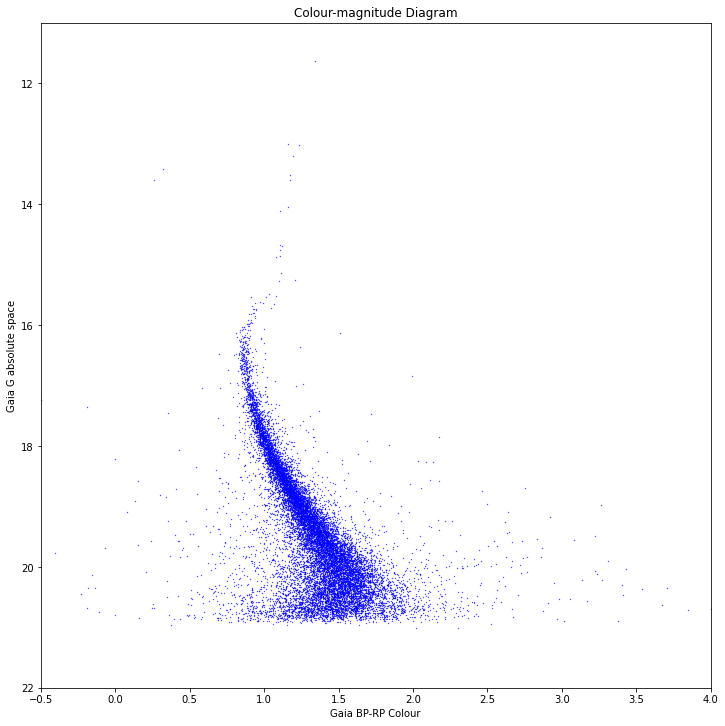

In [8]:
# Draw a colour-magnitude diagram

fig, ax = plt.subplots(ncols=1)
ax.invert_yaxis()
ax.set_xlabel('Gaia BP-RP Colour')
ax.set_ylabel('Gaia G absolute space')
ax.set(
    title=r'Colour-magnitude Diagram',
    xlim=[-0.5, 4.0],
    ylim=[22, 11]
)

#ax.scatter(gaia.data['bp_rp'][~cut], gaia.data['phot_g_mean_mag'][~cut], color='gray', marker='x', s=0.1)
ax.scatter(gaia.data['bp_rp'][cut], gaia.data['phot_g_mean_mag'][cut], color='b', s=0.1)


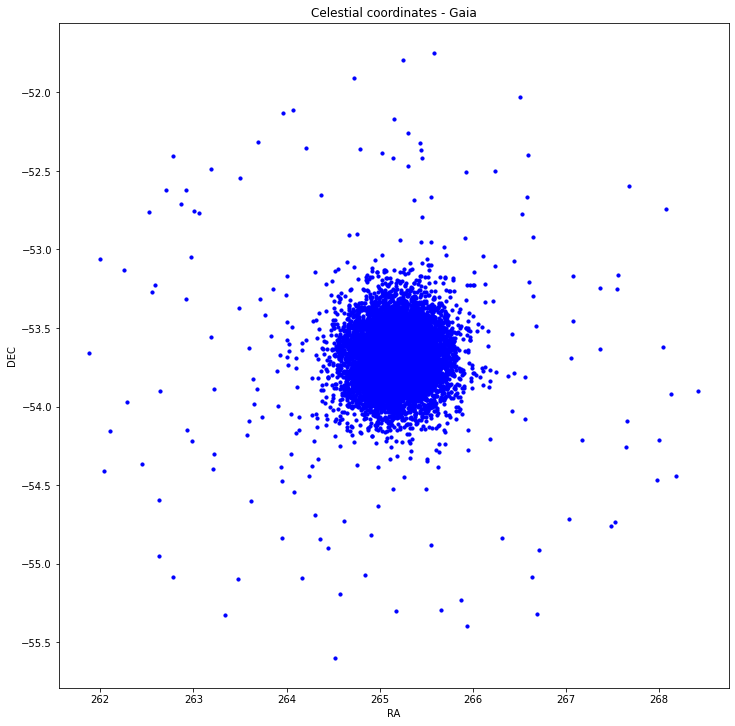

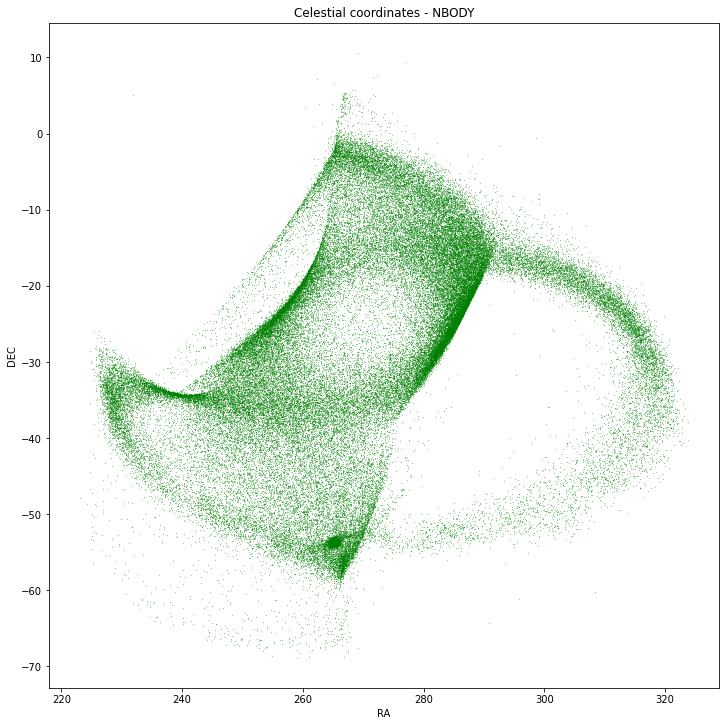

In [9]:

# Plot the spatial coordinates
fig, ax = plt.subplots(ncols=1)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_title('Celestial coordinates - Gaia')
ax.scatter(gaia.data['ra'][cut], gaia.data['dec'][cut], color='b', marker='o', s=10)


fig, ax = plt.subplots(ncols=1)

ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_title('Celestial coordinates - NBODY')
ax.scatter(nbody[:,1], nbody[:,2], color='g', marker='.', s=0.1)



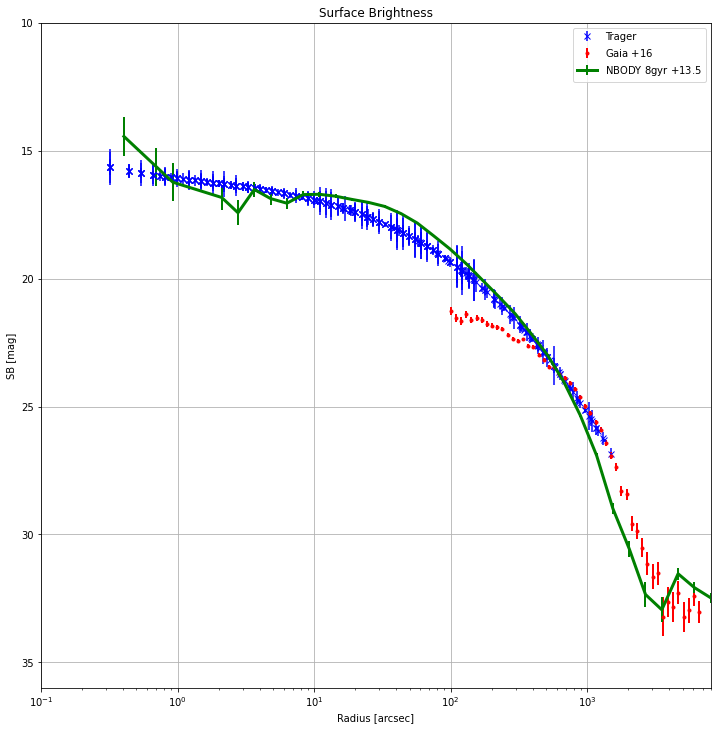

In [35]:
def sdens_to_sb(n):
    return (-2.5) * np.log10(n)

def surface_density(d, ax, label, scale=17, fmt='none', lw=2):
    logmin = np.amin(d)
    logmax = np.amax(d)
    logbins = np.logspace(np.log10(logmin), np.log10(logmax), 50)
    counts, bins = np.histogram(d, bins=logbins)
    cut = counts > 0
    
    # Divide the sum in each bin by the area of the annulus
    r_b = bins[:-1]
    area = np.array([
      np.pi * (bins[i+1]**2 - r**2)
      for i,r in enumerate(r_b)
    ])[cut]
    
    n_area = counts[cut] / area 
    nsq_area = np.sqrt(counts[cut]) / area 
    y = -2.5 * np.log10(n_area)
    
    error = -2.5 * np.log10(n_area+nsq_area) - y
    #error = np.log10(nsq_area)
    #error = np.log10(y) - np.log10(np.sqrt(counts[cut]))
    #error = y / np.sqrt(n_area)
    #err = (y / np.sqrt(n_area))
    
    ax.errorbar(r_b[cut], y+scale, fmt=fmt,
                yerr=np.abs(error), label=label, lw=lw, elinewidth=2)
    


# Stitch with Trager et al.
from geom import rad2arcsec
trager = np.loadtxt('ngc6397_trager.dat')

fig, ax = plt.subplots(ncols=1)

ax.set_title('Surface Brightness')
ax.set_xlabel(r'Radius [arcsec]')
ax.set_ylabel(r'SB [mag]')
ax.set_xscale("log")
ax.grid()
ax.invert_yaxis()
ax.set(
    ylim=[36, 10],
    xlim=[0.1, 8000]
)
# ax.set(title="Surface Density")

# Plot tager
# ax.plot(10**trager[:,0], trager[:,2], label='Trager')
trager_err = np.abs(trager[:,3])
cut_trager = trager_err < 1
ax.errorbar(10**trager[:,0][cut_trager], trager[:,2][cut_trager], yerr=trager_err[cut_trager], label='Trager', fmt='bx')


# Stitch Gaia
cut = cut & bright
gaia_cut = gaia.data[cut]
#arcsec_distance = rad2arcsec(angular_dist(gaia_cut['ra'], gaia_cut['dec'], orbits.RA, orbits.DEC))
arcsec_distance = 3600.0 * np.sqrt((gaia_cut['ra']-orbits.RA)**2 * np.cos(orbits.DEC/180.0*np.pi)**2+(gaia_cut['dec']-orbits.DEC)**2) 
surface_density(arcsec_distance[arcsec_distance > 100], ax, 'Gaia $+16$', scale=16, fmt='r.')

# Get nbody form
#m80 = (nbody[:,7] > 0.8) & (nbody[:,8] < 10)

#nbdis = rad2arcsec(angular_dist(nbody[:,1][m80], nbody[:,2][m80], orbits.RA, orbits.DEC))

#surface_density(nbdis, ax, 'NBODY 4gyr $+16$', fmt='g-', scale=16, lw=3)

# Get nbody form
#nbody8 = np.loadtxt('2023-02-09/ngc6397.out')
nbody8 = np.loadtxt('8gyr/ngc6397.out')
m80 = (nbody8[:,7] > 0.78) & (nbody8[:,7] < 0.9) & (nbody8[:,8] < 6)

# nbdis = rad2arcsec(angular_dist(nbody8[:,1][m80], nbody8[:,2][m80], orbits.RA, orbits.DEC))
nbdis = 3600.0 * np.sqrt((nbody8[:,1][m80]-orbits.RA)**2 * np.cos(orbits.DEC/180.0*np.pi)**2+(nbody8[:,2][m80]-orbits.DEC)**2) 
surface_density(nbdis, ax, 'NBODY 8gyr $+13.5$', fmt='g-', scale=15.5, lw=3)


ax.legend()

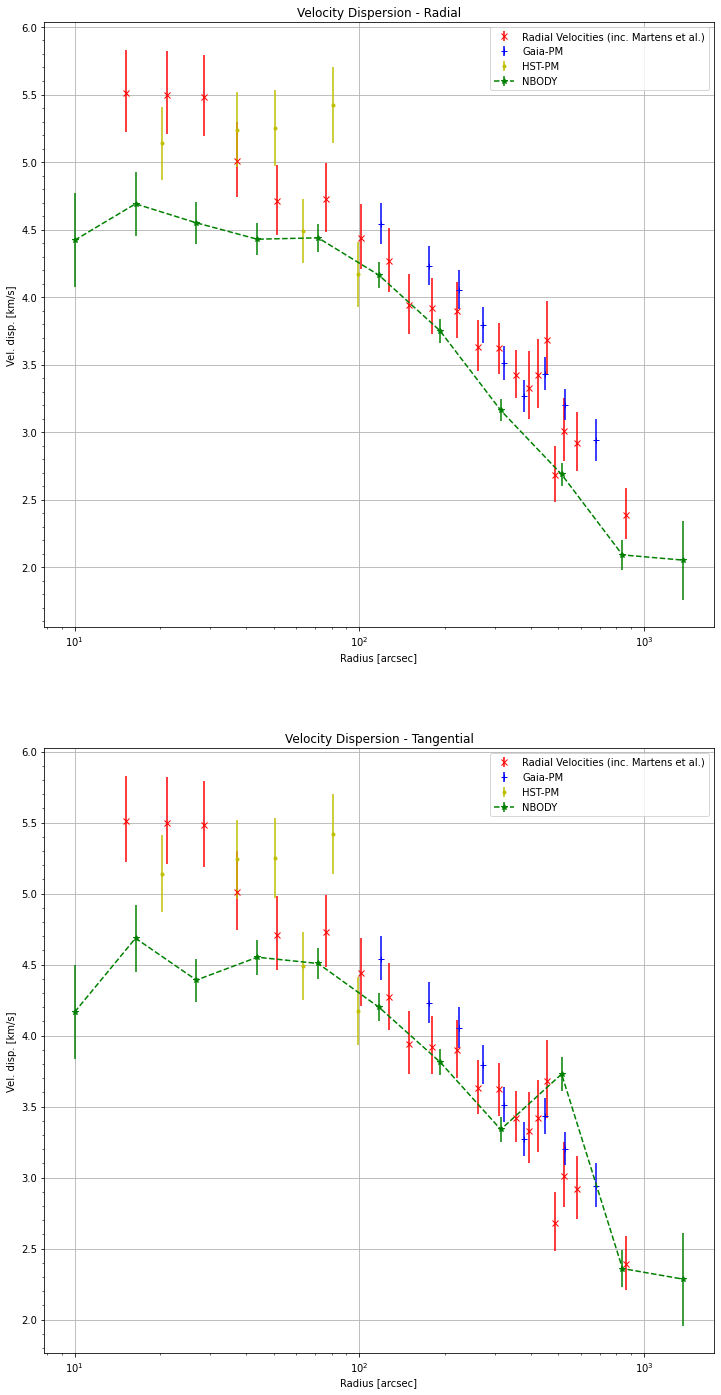

In [70]:
# Vel. disp.
from astropy import units as u
import veldis
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

fig, axes = plt.subplots(ncols=1, nrows=2, figsize=[12,24])


axes[0].set_title('Velocity Dispersion - Radial')
axes[1].set_title('Velocity Dispersion - Tangential')

for ax in axes:
    ax.set_xlabel(r'Radius [arcsec]')
    ax.set_ylabel(r'Vel. disp. [km/s]')
    ax.set_xscale("log")
    ax.grid()
    #ax.yaxis.grid(True, which='minor')
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))

def get_veldis(vel, dx):
    lo = 10
    hi = 2250
    
    logbins = np.logspace(np.log10(lo), np.log10(hi), num=12)
    
    hi = logbins[-1]
    nbinner = (dx < hi) & (dx >= lo)
    nb_v_mean = np.mean(vel[nbinner])
    
    hist = []
    bins = []
    errs = []
    for i,r in enumerate(logbins[:-1]):
        bds = (dx >= r) & (dx < logbins[i+1]) #& ((np.abs(vel-nb_v_mean)**2/nb_v_mean) < 10000)
        #print(np.amax((vel[bds]-nb_v_mean)**2/nb_v_mean))
        bds = bds & ((np.abs(vel-nb_v_mean)**2/nb_v_mean) < 1000)
        n = np.sum(bds)
        
        #print(nb_v_mean, np.sqrt(np.mean((vel[bds]-nb_v_mean)**2)))
        s = np.sqrt(1/n * np.sum((vel[bds] - nb_v_mean)**2.0))
        #print(r, np.amax(np.abs(vel[bds]-nb_v_mean)/nb_v_mean))
        #print(s, n)
        #s = np.sqrt(np.mean((vel[bds]-nb_v_mean)**2))
        #s = np.sqrt(1.0 / n * np.sum((vel[bds] - nb_v_mean)))
        #s = np.std(vel[bds])
        
        error = s / np.sqrt(n)

        hist.append(s)
        bins.append(r)
        errs.append(error)

    return hist, errs, bins


def tangent_to_velocity(mas):
    return mas.value/3600/180*np.pi * orbits.RSUN * 3.085677E16 / 3.15576e7 / 1000
    

def plot_veldis_nb(axes, label, fmt='g--*'):
    ax1, ax2 = axes
    
    m80 = (nbody8[:,8] < 6) & (nbody8[:,7] > 0.78) &  (nbody8[:,7] < 0.9)
    bright = nbody8[m80]
    
    #dcen = 3600.0*sqrt((rastar-racen)**2*cos(deccen/180.0*3.1415927)**2+(decstar-deccen)**2)
    nbdx = 3600.0 * np.sqrt((bright[:,1]-orbits.RA)**2 * np.cos(orbits.DEC/180.0*np.pi)**2+(bright[:,2]-orbits.DEC)**2) 
    
    #nbdx0 = rad2arcsec(angular_dist(bright[:,1], bright[:,2], orbits.RA, orbits.DEC)) * u.arcsec
    
    
    nbvr = bright[:,6] # * u.km/u.s
    nbvd, nberr, nbvb = get_veldis(nbvr, nbdx)
    ax1.errorbar(nbvb, nbvd, yerr=nberr, label='NBODY', fmt=fmt)
    
    ve = tangent_to_velocity(bright[:,4] * u.mas/u.yr)
    vn = tangent_to_velocity(bright[:,5] * u.mas/u.yr)
    nbpm = np.sqrt(ve**2 + vn**2)
    
    nbvd, nberr, nbvb = get_veldis(ve, nbdx)
    ax2.errorbar(nbvb, nbvd, nberr, label='NBODY', fmt=fmt)
    

def plot_veldis_type(ax, t, label, martens=False, fmt='.'):
    if not martens:
        vcut = (veldis.odata_latest['type'] == t) & (veldis.odata_latest['R'] > 10)
        verru = veldis.odata_latest['esig_u'][vcut]
        verrl = veldis.odata_latest['e_sigl'][vcut]
        verr = np.vstack((verrl, verru))
        ax.errorbar(veldis.odata_latest['R'][vcut], veldis.odata_latest['sig'][vcut], verr, label=label, fmt=fmt)

    else:
        vcut = (veldis.odata_martens['type'] == t) & (veldis.odata_martens['R'] > 10)
        verru = veldis.odata_martens['esig_u'][vcut]
        verrl = veldis.odata_martens['e_sigl'][vcut]
        verr = np.vstack((verrl, verru))
        ax.errorbar(veldis.odata_martens['R'][vcut], veldis.odata_martens['sig'][vcut], verr, label=label + " (inc. Martens et al.)", fmt=fmt)

plot_veldis_type(axes[0], 1, 'Radial Velocities', martens=True, fmt='rx')
plot_veldis_type(axes[1], 1, 'Radial Velocities', martens=True, fmt='rx')
plot_veldis_type(axes[0], 4, 'Gaia-PM', fmt='b+')
plot_veldis_type(axes[0], 2, 'HST-PM', fmt='y.')
plot_veldis_type(axes[1], 4, 'Gaia-PM', fmt='b+')
plot_veldis_type(axes[1], 2, 'HST-PM', fmt='y.')

plot_veldis_nb(axes, 'NBODY')

for ax in axes:
    ax.legend()




In [ ]:
bound = np.loadtxt('2023-02-09/bound')
fig, ax = plt.subplots(ncols=1, nrows=1)


ax.set(
 xlabel='Time',
 ylabel='Bound Ratio'
)
ax.grid()
ax.plot(bound[:,0], bound[:,2], label='Mass')
ax.plot(bound[:,0], bound[:,3], label='Stars')
ax.legend()

"""
ax = axes[1]
ax.set(
 xlabel='Time',
 ylabel='Radius [pc]'
)
ax.grid()
ax.plot(bound[:,0], bound[:,1])
"""

In [ ]:


fig, ax = plt.subplots(ncols=1, nrows=1, figsize=[12,24])

ax.set_title('Velocity Dispersion')
ax.set_xlabel(r'Radius [arcsec]')
ax.set_ylabel(r'Vel. disp. [km/s]')
ax.set_xscale("log")
ax.grid()

def plot_vd(ax, f, label, fmt):
    data = np.loadtxt(f)
    m80 = (data[:,7] > 0.8) & (data[:,8] < 10)
    bright = data[m80]
    #nbdx = rad2arcsec(angular_dist(bright[:,1], bright[:,2], orbits.RA, orbits.DEC)) * u.arcsec
    nbdx = 3600.0 * np.sqrt((bright[:,1]-orbits.RA)**2 * np.cos(orbits.DEC/180.0*np.pi)**2+(bright[:,2]-orbits.DEC)**2) 

    nbvr = bright[:,6] #* u.km/u.s
    nbvd, nberr, nbvb = get_veldis(nbvr, nbdx)
    ax.errorbar(nbvb, nbvd, nberr, label=label, fmt=fmt)
    
plot_vd(ax, 'ngc6397.out', '4 Gyr (1st model)', 'y--')
plot_vd(ax, '8gyr/ngc6397.out', '8 Gyr (1st model)', 'b--')
plot_vd(ax, '2023-02-09/ngc6397.out', '8 Gyr (1st model)', 'g--')
plot_veldis_type(ax, 1, 'Radial Velocities', martens=True, fmt='x')

ax.legend()